In [ ]:
#!pip install scikit-learn=='0.24.2' 

In [3]:
import transformers 
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt

### Read data

In [4]:
file = './data/dataset1.csv'
df = pd.read_csv(file)

### Viewing columns 'sentiScore' Distribution

In [5]:
df['sentiScore'].value_counts()

 3.0    1518
 2.0     918
-1.0     628
 4.0     242
-2.0     153
-3.0     132
-4.0      77
 5.0      15
-5.0       8
Name: sentiScore, dtype: int64

### Predictive label conversion

In [6]:
df['label'] = np.where(df['sentiScore']>0,1,0)

In [7]:
# Remove dirty data, e.g. null values, no label data

In [8]:
df = df[(df['id']>0) & (df['review'].str.len()>0)][['label','review']]

### Setting device as per the availability

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
# Pre-trained models using Roberta
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [11]:
# Using the Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Loading pre-trained Robert tokenizer 

100%|██████████| 3689/3689 [00:01<00:00, 3561.12it/s]
<ipython-input-12-18bf43279432>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


<Axes: ylabel='Density'>

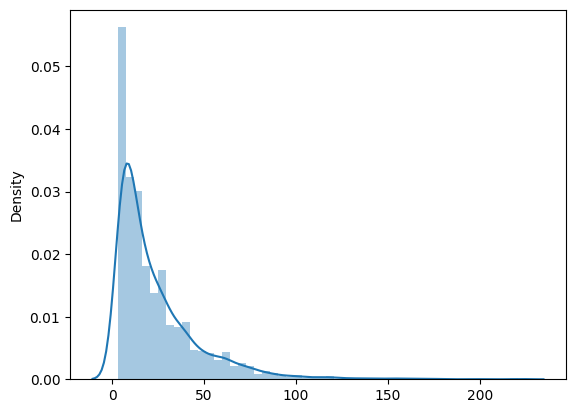

In [12]:
# Statistical distribution of sentence lengths
token_lens = []
for txt in tqdm(df.review):
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

sns.distplot(token_lens)

In [13]:
# The maximum sentence length can be chosen from the above diagram to be 100
# as most sentences are less than 100 in length
MAX_LEN = 100

In [14]:
# Encoding of the input sentence sequence
class ReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

### Creating Pytorch dataset by converting the text into numerical vectors using the tokenizer 

In [15]:
# dataset spliting
df_train = df.sample(frac=0.7,random_state=0,axis=0)
df_temp = df[~df.index.isin(df_train.index)]
df_val = df_temp.sample(frac=0.5,random_state=0,axis=0)
df_test = df_temp[~df_temp.index.isin(df_val.index)]

Train


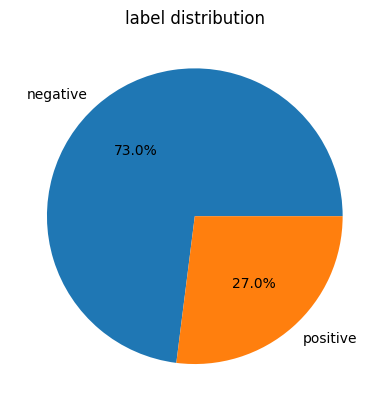

Label distribution:  {1: 1885, 0: 697}
Val


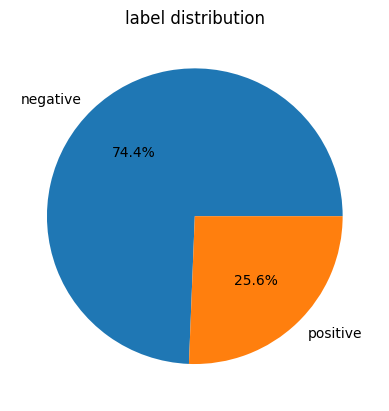

Label distribution:  {1: 412, 0: 142}
Test


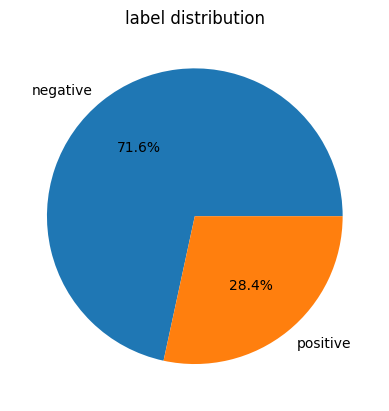

Label distribution:  {1: 396, 0: 157}


In [16]:
def describe_label_distribution(label):
    """plot the distribution of label"""
    plt.pie(label, labels=['negative','positive'], autopct='%1.1f%%')
    plt.title('label distribution')
    plt.show()
    print('Label distribution: ', label.to_dict())


print('Train')
describe_label_distribution(df_train.label.value_counts())
print('Val')
describe_label_distribution(df_val.label.value_counts())
print('Test')
describe_label_distribution(df_test.label.value_counts())

In [17]:
df_train.shape, df_val.shape, df_test.shape

((2582, 2), (554, 2), (553, 2))

In [18]:
# Obtain and calculate class weights. 
# Adding these weights to a small number of classes while training the model can improve the classification performance of the classes.
from sklearn.utils import class_weight

In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(df_train.label.values),
                                                 y=df_train.label.values)

In [20]:
# print class weights
class_weights

array([1.85222382, 0.68488064])

In [21]:
# Define data loader
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = ReviewDataset(
        reviews = df.review.to_numpy(), 
        targets = df.label.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=0)

### Creating Pytorch dataset loader 

In [22]:
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [23]:
# Download Roberta pre-trained model
bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
# define Roberta sentiment classifier
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
        self.drop = nn.Dropout(p=0.4)
        #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.drop1 = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask)
        output = self.drop(pooled_output)
        output = self.out1(output)
        output = self.relu(output)
        output = self.drop1(output)
        return self.out(output)

### Creating a fine-tuned bert model 

In [25]:
class_name = ['negative','positive']

In [26]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
# Define the rounds of training
EPOCHS = 5
# Use AdamW Optimiser
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# Define cross-entropy loss
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Initializing optimizer and loss function for our model

In [28]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

### Function to train our model on each epoch

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

### Function to evaluate the model

In [30]:
# Training process and print the loss and acc of train and val for each round
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/5
----------
Train loss 0.43733668676864956 accuracy 0.808288148721921
Val   loss 0.31401535413331455 accuracy 0.8971119133574007

Epoch 2/5
----------
Train loss 0.3251079103828948 accuracy 0.8745158791634392
Val   loss 0.2489634905424383 accuracy 0.9007220216606499

Epoch 3/5
----------
Train loss 0.2585334775072557 accuracy 0.9101471727343146
Val   loss 0.18393869284126493 accuracy 0.9368231046931408

Epoch 4/5
----------
Train loss 0.1851028651918894 accuracy 0.9442292796281953
Val   loss 0.21088021403799453 accuracy 0.9368231046931408

Epoch 5/5
----------
Train loss 0.14940538988621146 accuracy 0.9616576297443843
Val   loss 0.21202718114687336 accuracy 0.9404332129963899



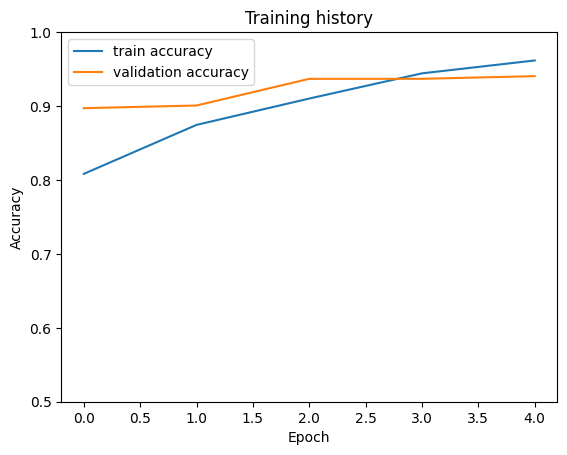

In [31]:
plt.plot(torch.tensor(history["train_acc"], device='cpu'), label='train accuracy')
plt.plot(torch.tensor(history["val_acc"], device='cpu'), label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);

In [32]:
# TestSet Evaluation
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


test_acc.item()

0.9421338155515371

In [33]:
# prediction validation
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [34]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Test prediction


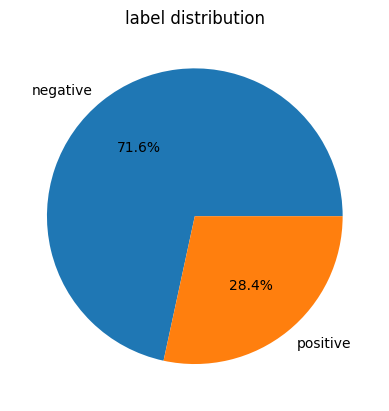

Label distribution:  {1: 396, 0: 157}
Train prediction


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


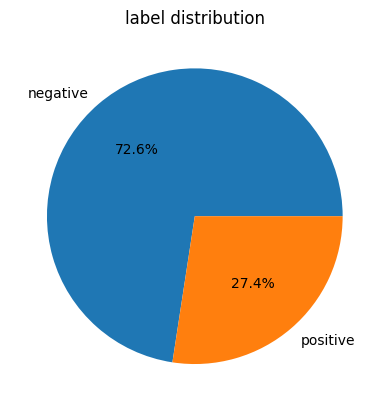

Label distribution:  {1: 1874, 0: 708}


In [35]:
print('Test prediction')
labels = pd.value_counts(y_pred.numpy())
for label in [0, 1]:
    if label not in labels.index:
        labels[label] = 0
describe_label_distribution(labels)


print('Train prediction')
_, y_train_pred, _, _ = get_predictions(
  model,
  train_data_loader
)
labels = pd.value_counts(y_train_pred.numpy())
for label in [0, 1]:
    if label not in labels.index:
        labels[label] = 0
describe_label_distribution(labels)

In [ ]:
# Reporting on indicators of classification results
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

    negative       0.92      0.89      0.90       157
    positive       0.96      0.97      0.96       396

    accuracy                           0.95       553
   macro avg       0.94      0.93      0.93       553
weighted avg       0.95      0.95      0.95       553



In [ ]:
# Dichotomous confusion matrix plotting and ROC curve plotting
def binary_performances(y_true, y_prob, thresh=0.5, labels=['Positives','Negatives']):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, auc, roc_curve
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh))
    
    plt.subplot(121)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
               'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
    
    #2 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(122)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()

    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    print(prints)
    
    return results

/tmp/ipykernel_180/1713052172.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  binary_performances(torch.tensor(y_test, device='cpu'), torch.tensor(y_pred, device='cpu'), thresh=0.5, labels=['Positives','Negatives'])


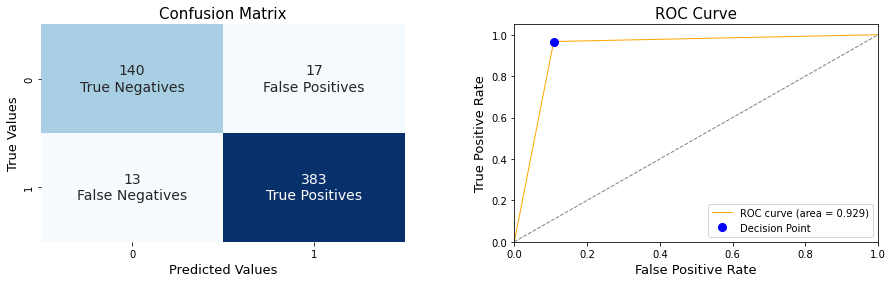

Precision: 0.958 | Recall: 0.967 | F1 Score: 0.962 | AUC: 0.929


{'Precision': 0.9575,
 'Recall': 0.9671717171717171,
 'F1 Score': 0.9623115577889447,
 'AUC': 0.9294457311973235}

In [ ]:
binary_performances(torch.tensor(y_test, device='cpu'), torch.tensor(y_pred, device='cpu'), thresh=0.5, labels=['Positives','Negatives'])

### Data prediction

In [ ]:
review_text = "the food was delicious but it was spicy"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/root/miniconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

Review text: the food was delicious but it was spicy
Sentiment  : positive
